In [1]:
import os
import torch
import torch.nn as nn
import glob
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import multiprocessing as mp
import pickle

import ExMAS
import utils
from ExMAS.utils import inData as inData
from torch.utils.data import  DataLoader
import seaborn as sns
import ExMAS_wrapper as ExMASFunc

Load run parameters

In [2]:
run_parameters = utils.get_initial_parameters('run_parameters_v2.json')
initial_params = ExMAS.utils.get_config(run_parameters.initial_parameters)
initial_params.duration_in_minutes = run_parameters.duration_in_minutes

In [3]:
demand_structure_requests = ExMASFunc.split_demand_structure(run_parameters)
print("Demand size: ", len(run_parameters.values_of_demand_variables[0]) * run_parameters.replications)

Demand size:  10


In [4]:
pool = mp.Pool(mp.cpu_count())
mp.cpu_count()

8

In [5]:
demand_dotmaps = [pool.apply(ExMASFunc.demand_generation, args=(initial_params, demand, True))
                  for demand in demand_structure_requests]

In [6]:
demand_dotmaps[0].requests[:5]

,origin,destination,treq,tdep,ttrav,tarr,tdrop,dist,pax_id
60,5715066940,4594247438,2022-02-28 15:00:17,NaN,0 days 00:52:23,2022-02-28 15:52:40,NaN,3143,60
38,44854736,894421661,2022-02-28 15:00:39,NaN,0 days 00:31:36,2022-02-28 15:32:15,NaN,1896,38
23,1583992769,44792321,2022-02-28 15:00:52,NaN,0 days 00:54:03,2022-02-28 15:54:55,NaN,3243,23
34,2598004622,1436427141,2022-02-28 15:01:15,NaN,0 days 00:17:36,2022-02-28 15:18:51,NaN,1056,34
37,44813599,44838797,2022-02-28 15:01:46,NaN,0 days 00:55:29,2022-02-28 15:57:15,NaN,3329,37


In [7]:
exmas_res = [pool.apply(ExMAS.main, args=(data, initial_params, False)) for data in demand_dotmaps]

In [8]:
pool.close()

In [9]:
exmas_res_extracted = [ExMASFunc.alter_kpis(data.sblts.res)['SavedVehHours'] for data in exmas_res]

In [10]:
exmas_res_extracted[:5]

[0.27198158008346524,
 0.23051881993896237,
 0.2744986757472569,
 0.25986971969996053,
 0.21050991795617405]

In [11]:
demand = [dem.requests for dem in demand_dotmaps]
demand[0][:3]

,origin,destination,treq,tdep,ttrav,tarr,tdrop,dist,pax_id
60,5715066940,4594247438,2022-02-28 15:00:17,NaN,0 days 00:52:23,2022-02-28 15:52:40,NaN,3143,60
38,44854736,894421661,2022-02-28 15:00:39,NaN,0 days 00:31:36,2022-02-28 15:32:15,NaN,1896,38
23,1583992769,44792321,2022-02-28 15:00:52,NaN,0 days 00:54:03,2022-02-28 15:54:55,NaN,3243,23


In [12]:
with open('demand.obj', 'wb') as demand_file:
  pickle.dump(demand, demand_file)

In [13]:
with open('kpis.obj', 'wb') as kpis_file:
  pickle.dump(exmas_res_extracted, kpis_file)

In [14]:
ExMAS.utils.load_G(inData, initial_params, stats=True);

In [15]:
origins, destinations = zip(*[utils.split_geo_positions(item, inData) for item in demand])

In [16]:
origins[0][:3]

,origin,time_request,x_geo,y_geo
0,5715066940,2022-02-28 15:00:17,4.359206,51.987170
1,44854736,2022-02-28 15:00:39,4.347923,52.012532
2,1583992769,2022-02-28 15:00:52,4.351989,51.984965


In [17]:
destinations[0][:3]

,destination,time_request,x_geo,y_geo
0,4594247438,2022-02-28 15:00:17,4.355876,52.009397
1,894421661,2022-02-28 15:00:39,4.343945,52.000152
2,44792321,2022-02-28 15:00:52,4.357743,51.998695


Geo-pandas - poprawa generacji grida; zapytania przestrzenne

### Choose one of the approaches

#### Multichannel approach - corresponding to time

In [18]:
grid = utils.create_time_space_grid(inData, number_of_space_points=10, parameters=initial_params)

pool = mp.Pool(mp.cpu_count())
map_origins = [pool.apply(utils.apply_time_space_grid, args=(data, grid)) for data in origins]
map_destinations = [pool.apply(utils.apply_time_space_grid, args=(data, grid)) for data in destinations]
pool.close()

demand_list_tensors = utils.merge_origins_destinations(map_origins, map_destinations)

#### Snapshot approach

In [18]:
grid = utils.create_space_grid(inData, 10)

pool = mp.Pool(mp.cpu_count())
map_origins = [pool.apply(utils.apply_space_grid, args=(data, grid)) for data in origins]
map_destinations = [pool.apply(utils.apply_space_grid, args=(data, grid)) for data in destinations]
pool.close()

demand_list_tensors = utils.merge_origins_destinations(map_origins, map_destinations)

### End of difference between approaches

In [19]:
demand_list_tensors[0].shape

torch.Size([2, 10, 10])

In [20]:
demand_list_tensors[0]

tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  2.,  1.,  4.,  5.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  1.,  2.,  0.,  1.,  1.,  0.,  0.,  0.,  0.],
         [ 0.,  2.,  5.,  2.,  0.,  1.,  1.,  0.,  0.,  0.],
         [ 0.,  2.,  1.,  3.,  2.,  1.,  1.,  2.,  0.,  0.],
         [ 2.,  1.,  1.,  4.,  1.,  0.,  3.,  1.,  0.,  0.],
         [ 0.,  0.,  1.,  0.,  0.,  3.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  1.,  2.,  1.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  1.,  1.,  3.,  3.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  2.,  3., 12.,  2.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  3.,  2

In [21]:
results_list_tensors = [torch.tensor(a) for a in exmas_res_extracted]
results_list_tensors[0]

tensor(0.2720)

In [22]:
whole_dataset = utils.WholeDataset(demand_list_tensors, results_list_tensors)
train_size = int(0.8 * len(whole_dataset))
test_size = len(whole_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(whole_dataset, [train_size, test_size])

In [23]:
torch.save(train_dataset, 'train_dataset.pt')
torch.save(test_dataset, 'test_dataset.pt')

In [72]:
train_dataset = torch.load('train_dataset.pt')
test_dataset = torch.load('test_dataset.pt')

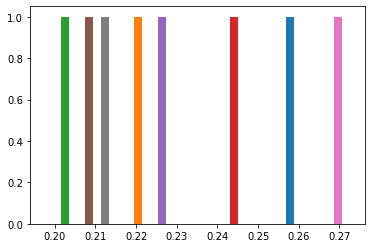

In [24]:
kpis = [train_dataset.dataset.labels[t] for t in train_dataset.indices]
plt.hist(kpis, bins=4)
plt.show()

More sofisticated VAE can be taken from: https://github.com/AntixK/PyTorch-VAE

# Neural Network

## Autoencoder

In [25]:
import torch
import torch.nn as nn

import numpy as np

from torchvision.utils import save_image, make_grid
import torch.nn.functional as F

In [285]:
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

batch_size = 4

x_dim  = 2*10*10
hidden_dim = 100
latent_dim = 32

lr = 1e-3
epochs = 30
DEVICE

## Load data

In [286]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers = 4)

In [287]:
x,y = next(iter(train_loader))
x.shape

torch.Size([4, 2, 10, 10])

### Encoder

In [288]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     
        
        return mean, log_var

In [289]:
class Encoder2(nn.Module):
    
    def __init__(self, latent_dim, input_channels):
        super(Encoder2, self).__init__()
        
        self.latent_dim = latent_dim

        modules = []
        hidden_dims = [32, 64, 128, 256, 512,1000]
        in_channels = input_channels

        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels=in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
#         self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
#         self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)
        
        self.training = True
        
    def forward(self, x):
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1)

        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return mu, log_var

### Decoder

In [290]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [291]:
class Decoder2(nn.Module):
    def __init__(self, latent_dim, batch_size):
        super(Decoder2, self).__init__()
        
        hidden_dims = [32, 64, 128, 256, 512]
        hidden_dims.reverse()
        
#         self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1]*10*10)
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1])
        
        modules = []
        
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 2,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())
        
    def forward(self, x):
        print('Input for decoder: ', x.shape)
        result = self.decoder_input(x)
        print('Decoder_input:', result.shape)
#         result = result.view(-1, 512, 2, 2)
#         result = result.view(-1, 2, 10, 10)
        print('Results shape:', result.shape)
        result = self.decoder(result)
        result = self.final_layer(result)

        return result

### Together

In [292]:
class VAE(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(VAE, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
                  
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.Decoder(z)
        
        return x_hat, mean, log_var

## Model declaration

In [293]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
encoder2 = Encoder2(latent_dim=20, input_channels=2)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)
decoder2 = Decoder2(latent_dim=20, batch_size=batch_size)

autoencoder = VAE(Encoder=encoder2, Decoder=decoder2).to(DEVICE)

## Loss function and optimizer

In [294]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(autoencoder.parameters(), lr=lr)

## Training

In [295]:
print("Start training VAE...")
autoencoder.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
#         x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = autoencoder(x)
        print('x: ', x.shape, '/n')
        print('x_hat: ', x_hat.shape, '/n')
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    if epoch % 5 == 0:
        print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!")

Start training VAE...
Input for decoder:  torch.Size([4, 20])
Decoder_input: torch.Size([4, 32])
Results shape: torch.Size([4, 32])


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [512, 256, 3, 3], but got 2-dimensional input of size [4, 32] instead

## New representation, example

In [37]:
x, y = next(iter(train_loader))
x = x.view(batch_size, x_dim)
x = x.to(DEVICE)
print('Input: ', x, '\n')
x_hat, mean, log_var = autoencoder(x)
print('Modelled hidden: \n mean: ', mean, '\n log variance: ', log_var, '\n decoded to original:', x_hat)

Input:  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 3., 2., 2., 2., 2., 0., 0., 0., 0., 0., 1., 4., 2., 3., 1.,
         0., 0., 0., 0., 0., 2., 3., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         2., 1., 0., 0., 0., 0., 0., 2., 1., 6., 1., 1., 1., 0., 0., 0., 1., 2.,
         2., 0., 3., 2., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 3., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 1.,
         3., 0., 0., 0., 0., 0., 0., 3., 5., 9., 2., 0., 0., 0., 0., 0., 2., 0.,
         3., 7., 5., 0., 0., 0., 0., 0., 0., 2., 2., 1., 1., 1., 0., 0., 0., 0.,
         0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
  

In [38]:
mean.shape

torch.Size([4, 20])

## Network

#### Amend the representation

In [39]:
demand_list = [x.view(1, x_dim).to(DEVICE) for x in demand_list_tensors]

In [40]:
new_representation = [torch.cat(autoencoder.Encoder(x.view(1, x_dim).to(DEVICE))).detach() for x in demand_list_tensors]

In [41]:
new_representation[0].shape

torch.Size([2, 20])

In [42]:
new_dataset = utils.WholeDataset(new_representation, results_list_tensors)
train_size = int(0.8 * len(whole_dataset))
test_size = len(whole_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(new_dataset, [train_size, test_size])

In [43]:
torch.save(train_dataset, 'train_dataset_encoded.pt')
torch.save(test_dataset, 'test_dataset_encoded.pt')

### Network

#### Network

In [44]:
class Net(nn.Module):
    def __init__(self, padding=0):
        super().__init__()
        self.padding = padding
        self.conv1 = nn.Conv1d(2, 8, 4, padding=self.padding, stride=2)
        self.conv2 = nn.Conv1d(8, 32, 3, padding=self.padding, stride=1)
        self.conv1_drop = nn.Dropout2d()
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(224, 128)
        self.fc2 = nn.Linear(128, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.conv1_drop(self.conv1(x)))
        x = F.relu(self.conv2_drop(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Parameters

In [45]:
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

batch_size = 8

lr = 1e-3
epochs = 30
DEVICE

device(type='cuda')

#### Preparation

In [46]:
net = Net().cuda()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr)

 ####### Epoch: 9 #######
Train loss: 0.0055
Test loss: 0.0318


 ####### Epoch: 19 #######
Train loss: 0.0058
Test loss: 0.0122


 ####### Epoch: 29 #######
Train loss: 0.0054
Test loss: 0.0100




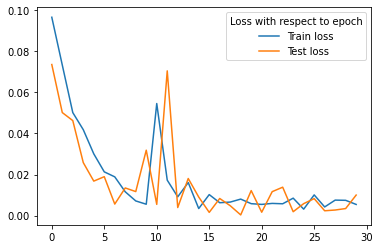

In [47]:
utils.train_net(net, criterion, optimizer, train_loader, test_loader, epochs, use_gpu=True)